### Loading HiC data

DONE IN COMMAND LINE: <br>
hifive fends --binned 100 -L genome/mm9.len fendsoutput <br>
hifive hic-data fendoutput -X data/WT_100Kb/raw_\*.mat hic-data-output <br>
hifive hic-project hic-data-output -f 25 -n 25 -j 100000 hic-project <br>
hifive hic-normalize express -f 25 -w cis hic-project <br>

### Working with the HiC data

In [1]:
import hifive
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# load in hicproject 
hic=hifive.HiC('hicproject', 'r')

In [3]:
# get data at 1Mb resolution - returns 3D matrix
data = hic.cis_heatmap('chr13', 1000000, datatype='fend', arraytype='full', diagonalincluded=True)

Finding fend full array for chr13:1000000-120250001... Done


In [4]:
# save raw and expected data (add 1 to neutralize zeros in the denominator in the enrichment calc)
raw = data[:, :, 0] + 1
expect = data[:, :, 1] + 1

In [5]:
# calculate enrichment and log enrichment 
enrichment = raw/expect                  
log_enrich = np.log(enrichment + 0.1)

Text(0.5,1,'Chromosome 13 HiC')

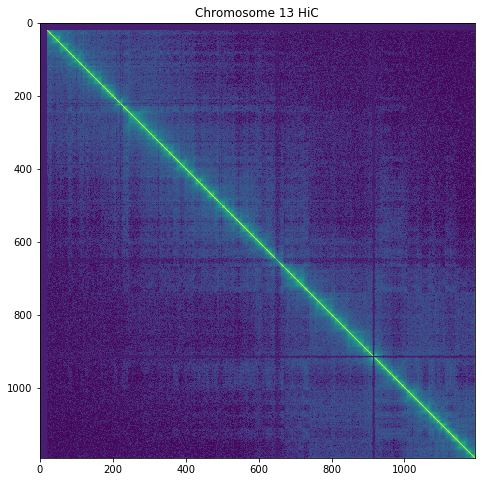

In [6]:
# plot heatmap using imshow() from matplotlib
fig = plt.figure(figsize = (8.0,8.0))
ax = fig.subplots()
im = ax.imshow(log_enrich)
ax.set_title('Chromosome 13 HiC')

### Compartment analysis

In [7]:
# correlates rows with columns of hic and results in positions with the resulting eignevector - compartment score
# creates a bedfile with these scores and chromosome position information
Comp = hifive.hic_domains.Compartment(hic, 100000, chroms=['chr13'], out_fname='tmp.hdf5')
Comp.write_eigen_scores('hic_comp.bed')

Casting complex values to real discards the imaginary part


Casting complex values to real discards the imaginary part


Text(0.5,0,'start position')

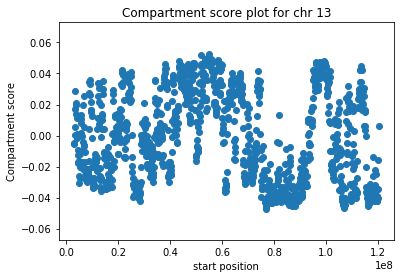

In [8]:
# extract the positions and compartment scores
X = Comp.positions['chr13']
Y = Comp.eigenv['chr13']
# plot these scores
plt.scatter(X[:,0], Y)
plt.title('Compartment score plot for chr 13')
plt.ylabel('Compartment score')
plt.xlabel('start position')

In [9]:
# Use grep to create a file with only negative or positivie scores

In [10]:
%%bash
grep -e - hic_comp.bed > neg_comp_score.bed
grep -v - hic_comp.bed > pos_comp_score.bed

In [11]:
# Use bedtools intersect to find genes from the WT_fpkm file that fall into the negative or positive compartment
# -wo prints both file A and B contents, -f 0.5 is a minimum overlap as a fraction of A. Such that 50 
# percent of the gene must be within the compartment range

In [12]:
%%bash
bedtools intersect -wo -f 0.5 -a data/WT_fpkm.bed -b neg_comp_score.bed > comp_b.bed
bedtools intersect -wo -f 0.5 -a data/WT_fpkm.bed -b pos_comp_score.bed > comp_a.bed

In [13]:
# Read resulting files into pandas dataframe
file_a = '/Users/cmdb/qbb2020-answers/week10-hw/comp_a.bed'
file_b = '/Users/cmdb/qbb2020-answers/week10-hw/comp_b.bed'
col = ['chr', 'gene-start', 'gene-stop', 'gene-name', 'fpkm', 'chr-comp', 'comp-start', 'comp-stop', 'comp-score', 'overlap']
comp_a = pd.read_csv(file_a, sep='\t', names = col)
comp_b = pd.read_csv(file_b, sep='\t', names = col)
# Add column for log2-fpkm (must add 0.1 to neutralize zeros)
comp_a['log2-fpkm'] = np.log2(comp_a['fpkm'] + 0.1)
comp_b['log2-fpkm'] = np.log2(comp_b['fpkm'] + 0.1)
comp_a.loc[0:3]

,chr,gene-start,gene-stop,gene-name,fpkm,chr-comp,comp-start,comp-stop,comp-score,overlap,log2-fpkm
0,chr13,3477549,3491644,2810429I04Rik,6.992451,chr13,3400000,3500000,0.017047,14095,2.826284
1,chr13,3497296,3500639,1700024F13Rik,1.282941,chr13,3400000,3500000,0.017047,2704,0.467740
2,chr13,3537321,3565507,Gdi2,467.203283,chr13,3500000,3600000,0.028550,28186,8.868215
3,chr13,3633278,3651025,Asb13,5.976786,chr13,3600000,3700000,0.021227,17747,2.603309


In [14]:
comp_b.loc[0:3]

,chr,gene-start,gene-stop,gene-name,fpkm,chr-comp,comp-start,comp-stop,comp-score,overlap,log2-fpkm
0,chr13,3148721,3188924,Speer6-ps1,0.000000,chr13,3100000,3200000,-0.004578,40203,-3.321928
1,chr13,4058837,4089668,Akr1c14,0.104918,chr13,4000000,4100000,-0.000716,30831,-2.286880
2,chr13,4131861,4149892,Akr1c18,0.182049,chr13,4100000,4200000,-0.001675,18031,-1.825983
3,chr13,4190433,4204849,Akr1c13,1.032640,chr13,4100000,4200000,-0.001675,9567,0.179689


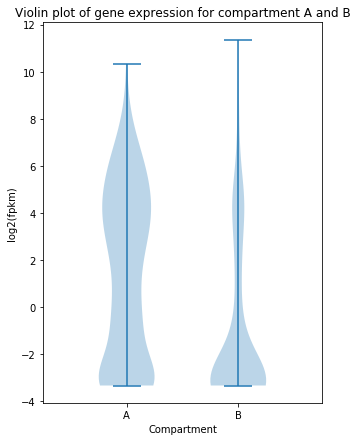

In [15]:
# function that sets up axes to add labels 
def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    
# plot the violinplot
fig = plt.figure(figsize = (5.0,7.0))
ax = fig.subplots()
vio_plot = ax.violinplot([comp_a['log2-fpkm'],comp_b['log2-fpkm']])
ax.set_title('Violin plot of gene expression for compartment A and B')
labels = ['A', 'B']
ax.set_xlabel('Compartment')
ax.set_ylabel('log2(fpkm)')
set_axis_style(ax, labels)

### Expression vs. Repression

In [16]:
import pyBigWig
bw = pyBigWig.open('data/WT_H3K27me3.bw')
H3K27_list = []

for row in comp_a.iterrows():
    gene_start = row[1]['gene-start']
    gene_stop = row[1]['gene-stop']
    me = bw.stats('chr13', gene_start, gene_stop, type='sum')
    if me[0] != None: 
        H3K27_list.append(me[0])
    elif me[0] == None: 
        H3K27_list.append(0)
comp_a['H3K27me3'] = H3K27_list
comp_a['log2-H3K27me3'] = np.log2(comp_a['H3K27me3'] + 0.1)

H3K27_list = []
for row in comp_b.iterrows():
    gene_start = row[1]['gene-start']
    gene_stop = row[1]['gene-stop']
    me = bw.stats('chr13', gene_start, gene_stop, type='sum')
    if me[0] != None: 
        H3K27_list.append(me[0])
    elif me[0] == None: 
        H3K27_list.append(0)
comp_b['H3K27me3'] = H3K27_list
comp_b['log2-H3K27me3'] = np.log2(comp_b['H3K27me3'] + 0.1)

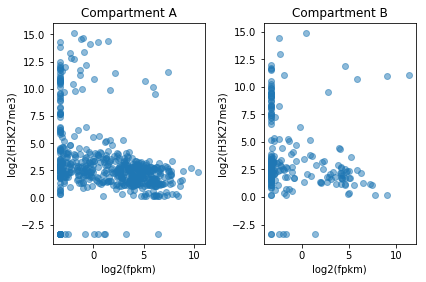

In [17]:
fig, ax = plt.subplots(1,2)

ax[0].scatter(comp_a['log2-fpkm'], comp_a['log2-H3K27me3'], alpha = 0.5)
ax[1].scatter(comp_b['log2-fpkm'], comp_b['log2-H3K27me3'], alpha = 0.5)
ax[0].set_title('Compartment A')
ax[1].set_title('Compartment B')
ax[0].set_ylabel('log2(H3K27me3)')
ax[1].set_ylabel('log2(H3K27me3)')
ax[0].set_xlabel('log2(fpkm)')
ax[1].set_xlabel('log2(fpkm)')

fig.tight_layout(pad = 1.0)

plt.show()